# Amazon Food Reviews

Data Source:https://www.kaggle.com/snap/amazon-fine-food-reviews

This dataset consists of reviews of fine foods from Amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

![alt text](http://nycdatascience.com/blog/wp-content/uploads/2016/04/NewCover.png)

#### Data includes:
- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews

#### Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

![alt text](http://nycdatascience.com/blog/wp-content/uploads/2016/04/AmazonReview.png)


### Objective:- Review Polarity
Given a review, determine the review is positive or neagative

#### Using text review to decide the polarity
Take the summary and text of review and analyze it using NLP whether the customer feedback/review is positive or negative


In [2]:
# !pip install --upgrade pip
# !pip install qtconsole ipywidgets widgetsnbextension
# !pip install seaborn
# !pip install nltk
# import nltk
# nltk.download("stopwords")
# !pip install gensim

In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
from time import time
import random
import gensim

%matplotlib inline 
# sets the backend of matplotlib to the 'inline' backend:
#With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook,
#directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

#Functions to save objects for later use and retireve it
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [4]:
# !wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.139 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" "https://storage.googleapis.com/kaggle-datasets/18/2157/database.sqlite.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1526375292&Signature=G95OD7LgGsnAoencBUsNHa3R2iIGiXOhdITLbhQVxqZ9IGS3JA9ETgbJRa3tHTguzL0ignoIz2sjQUxyY2YbcD98XR8immdcAmrFlQVA6Jm%2BBju%2BpDGjF05FpW0wGeMq6utKq2Qy8eMtm3NW%2FA%2F7m557B%2Bi3kGcBP4uaEzMk6F%2BpGaZnxcroDAcjpSj9VzU03INKPwpkbxtM%2FrWCaX748Bpgx9uKqwfrRakGR%2BRCpnMHcUukj%2FhaKKRi9QoQaTNpdRjmVB%2FqewKwDXTN8sr701yMkmqItQXBJI9Y312GqSP3Vd%2B3oleta5HZ2L9xlBFyUcLoyUEItOxI4pTjukwu1A%3D%3D" -O "database.sqlite.zip" -c

### Loading the data

In [17]:
#Using sqlite3 to retrieve data from sqlite file

con = sql.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
df = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...


In [18]:
df.describe()

,index,Id,HelpfulnessNumerator,HelpfulnessDenominator,Time
count,364171.000000,364171.000000,364171.000000,364171.000000,3.641710e+05
mean,241825.377603,261814.561014,1.739021,2.186841,1.296135e+09
std,154519.869452,166958.768333,6.723921,7.348482,4.864772e+07
min,0.000000,1.000000,0.000000,0.000000,9.393408e+08
25%,104427.500000,113379.500000,0.000000,0.000000,1.270858e+09
50%,230033.000000,249445.000000,0.000000,1.000000,1.311379e+09
75%,376763.500000,407408.500000,2.000000,2.000000,1.332893e+09
max,525813.000000,568454.000000,866.000000,878.000000,1.351210e+09


In [19]:
df.shape
df['Score'].size

364171

<b>-> For EDA Refer other ipynb notebook<b>

Score as positive or negative

In [21]:
def polarity(x):
    if x == "Positive":
        return 0
    else:
        return 1
df["Score"] = df["Score"].map(polarity) #Map all the scores as the function polarity i.e. positive or negative
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,0,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,1,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,0,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...


In [22]:
#Taking Sample Data
n_samples = 25000
df_sample = df.sample(n_samples)
df_sample.sort_values('Time',inplace=True) #Sorting as we want according to time series
df_sample.head(10)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
117901,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,0,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
169281,212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,0,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
169328,212519,230334,B00004RYGX,A1GB1Q193DNFGR,Bruce Lee Pullen,5,5,0,970531200,Fabulous Comedic Fanasy Directed by a Master,Beetlejuice is an awe-inspiring wonderfully am...,b'beetlejuic wonder amus comed romp explor inc...
169280,212471,230284,B00004RYGX,A1HWMNSQF14MP8,will@socialaw.com,1,2,0,978134400,A Afterlife Success,"Many movies, have dealt with the figure of dea...",b'mani movi dealt figur death dead good angel ...
169263,212454,230265,B00004RYGX,AZRJH4JFB59VC,Lynwood E. Hines,21,23,1,997228800,"Great movie, terrible DVD",I am continually amazed at the shoddy treatmen...,b'continu amaz shoddi treatment movi get dvd r...
169279,212470,230283,B00004RYGX,A31RM5QU797HPJ,Drez,1,2,0,1024531200,"&quot;I'm the ghost with the most, babe&quot;",Simply put: Beetlejuice is the funniest comedy...,b'simpli beetlejuic funniest comedi kind sinc ...
161885,202469,219388,B00005IX98,A24IUOMVERXVEG,"Rick ""rick_street""",11,11,0,1036108800,Great Easy cup of Espresso,I've purchased both the Espressione Espresso (...,b'ive purchas espression espresso classic arab...
169260,212451,230262,B00004RYGX,API663PFYRQCP,Donn Hart,66,67,0,1037750400,"Say it once, say it twice, third time's the ch...",When this movie first came out about fifteen y...,b'movi first came fifteen year ago father own ...
161893,202477,219396,B00005IX98,AGUF1WPEG4GSM,"""lchang44""",5,8,1,1055376000,"Almost expired, Sept '03",I returned this due to the very short/brief ex...,b'return due shortbrief expir date sept would ...
280071,388413,419994,B0000A0BS5,A238V1XTSK9NFE,Andrew Lynn,46,59,1,1064361600,Not actually for use in espresso machines,Few things I'd like to point out:<p>1. &quot;...,b'thing like point not roast drink northern it...


In [23]:
savetofile(df_sample,"sample_25000_knn")

In [7]:
df_sample = openfromfile("sample_25000_knn")

# KNN Models using Different Vectorizing Techniques in NLP

## Bag of Words (BoW)

A commonly used model in methods of Text Classification. As part of the BOW model, a piece of text (sentence or a document) is represented as a bag or multiset of words, disregarding grammar and even word order and the frequency or occurrence of each word is used as a feature for training a classifier.<br>
OR <br>
Simply,Converting a collection of text documents to a matrix of token counts

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

#Text -> Uni gram Vectors
uni_gram = CountVectorizer() #in scikit-learn
uni_gram_vectors = uni_gram.fit_transform(df_sample['CleanedText'].values)
uni_gram_vectors.shape 

(25000, 34085)

In [23]:
from sklearn import preprocessing
uni_gram_vectors_norm = preprocessing.normalize(uni_gram_vectors)
print(uni_gram_vectors_norm.min())
print(uni_gram_vectors_norm.max())

0.0
0.880704845928


In [24]:
#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(uni_gram_vectors_norm,df_sample['Score'].values,test_size=0.3,shuffle=False)
# print(X_train[:5])
# print(y_train[:5])
print(X_train[:2].toarray())

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [28]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):
#     print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)

(1600, 34085) (1590, 34085)
(3190, 34085) (1590, 34085)
(4780, 34085) (1590, 34085)
(6370, 34085) (1590, 34085)
(7960, 34085) (1590, 34085)
(9550, 34085) (1590, 34085)
(11140, 34085) (1590, 34085)
(12730, 34085) (1590, 34085)
(14320, 34085) (1590, 34085)
(15910, 34085) (1590, 34085)


Example how Time Series Splits data

In [29]:
%%time
from sklearn.neighbors import KNeighborsClassifier
n_splits = 10  #No of splits for Forward Chaining Cross Validation 
neigh_max = 100#Max no. of neighbours for KNN

tscv = TimeSeriesSplit(n_splits=n_splits)
k_acc = []#To store accuracy of different k values
for k in range(1,neigh_max,2):
    acc_list = []#To store accuracy of different fold
    for train, cv in tscv.split(X_train):
          if(train.size > k): 
            knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute',n_jobs=-1)
            knn.fit(X_train[train],y_train[train])
            acc_list.append(knn.score(X_train[cv],y_train[cv])*100)
    if(acc_list):        
        acc_nparr = np.array(acc_list) 
    k_acc.append(acc_nparr.mean())
k_acc = np.array(k_acc)    

CPU times: user 2min 45s, sys: 1min 24s, total: 4min 10s
Wall time: 6min 5s


In [30]:
savetofile(k_acc,"k_acc_uni_gram")

In [2]:
k_acc_uni_gram = openfromfile("k_acc_uni_gram")

In [32]:
k_acc_uni_gram

array([ 82.12578616,  84.87421384,  85.40251572,  85.81761006,
        85.9245283 ,  85.88050314,  85.86792453,  85.8490566 ,
        85.6918239 ,  85.66666667,  85.68553459,  85.64150943,
        85.57861635,  85.58490566,  85.51572327,  85.5408805 ,
        85.46540881,  85.40251572,  85.3836478 ,  85.34591195,
        85.3081761 ,  85.25786164,  85.22641509,  85.24528302,
        85.21383648,  85.17610063,  85.18238994,  85.1572327 ,
        85.11320755,  85.12578616,  85.13207547,  85.10691824,
        85.13207547,  85.10691824,  85.12578616,  85.12578616,
        85.09433962,  85.08805031,  85.06289308,  85.05660377,
        85.05031447,  85.06918239,  85.06289308,  85.03773585,
        85.01257862,  85.02515723,  85.04402516,  85.00628931,
        85.01257862,  85.        ])

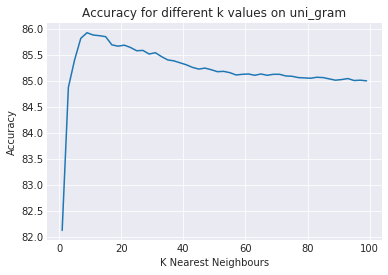

In [33]:
sns.set_style("darkgrid")
plt.plot(np.arange(1,100,2),k_acc_uni_gram)
plt.xlabel("K Nearest Neighbours")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k values on uni_gram")
plt.show()


With k=11-13 uni_gram has the highest accuracy of 86%

### Grid Search CV
For making the above code compact and get the best params 

In [ ]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='brute',n_jobs=-1)
# neigh = np.arange(1,100,2)
param_grid = {'n_neighbors':np.arange(1,100,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,n_jobs=-1)
gsv.fit(X_train,y_train)
print(gsv.best_score_)

In [33]:
print(gsv.best_params_)

{'n_neighbors': 11}


In [36]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train,y_train)
score = knn.score(X_test,y_test)
print("Accuracy on training set: %0.3f%%"%(score*100))

Accuracy on training set: 83.613%


In [37]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train,y_train)
score = knn.score(X_test,y_test)
print("Accuracy on training set: %0.3f%%"%(score*100))

Accuracy on training set: 83.680%


### bi-gram

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
#taking one words and two consecutive words together
bi_gram = CountVectorizer(ngram_range=(1,2))
bi_gram_vectors = bi_gram.fit_transform(df_sample['CleanedText'].values)
bi_gram_vectors.shape

(50000, 846601)

In [13]:
from sklearn import preprocessing
bi_gram_vectors_norm = preprocessing.normalize(bi_gram_vectors)

In [48]:
from sklearn.model_selection import train_test_split
#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(bi_gram_vectors_norm,df_sample['Score'].values,test_size=0.3,shuffle=False)

In [17]:
%%time
from sklearn.neighbors import KNeighborsClassifier
n_splits = 10  #No of splits for forward chaining Cross Validation 
neigh_max = 100#Max no. of neighbours for KNN

tscv = TimeSeriesSplit(n_splits=n_splits)
k_acc = []
for k in range(1,neigh_max,2):
    acc_list = []
    for train, cv in tscv.split(X_train):
          if(train.size > k): 
            knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute',n_jobs=-1)
            knn.fit(X_train[train],y_train[train])
            acc_list.append(knn.score(X_train[cv],y_train[cv])*100)
    if(acc_list):        
        acc_nparr = np.array(acc_list) 
    k_acc.append(acc_nparr.mean())
k_acc = np.array(k_acc)    

CPU times: user 9min 26s, sys: 3min 31s, total: 12min 57s
Wall time: 15min 57s


In [18]:
#Saving the variable to access later without recomputing
savetofile(k_acc,"k_acc_bi_gram")

In [19]:
#Loading the variable from file
k_acc_bi_gram = openfromfile("k_acc_bi_gram")

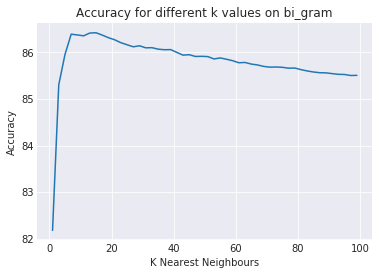

In [20]:
sns.set_style("darkgrid")
plt.plot(np.arange(1,neigh_max,2),k_acc_bi_gram)
plt.xlabel("K Nearest Neighbours")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k values on bi_gram")
plt.show()


With k=13 bi_gram has the highest accuracy of 86.5% in Cross Validation

In [49]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train,y_train)
score = knn.score(X_test,y_test)
print("Accuracy on training set: %0.3f%%"%(score*100))

Accuracy on training set: 85.033%


## tf-idf

TFIDF = TF x IDF<br>
<br>Term Frequency: This summarizes how often a given word appears within a document.<br>
Inverse Document Frequency: This downscales words that appear a lot across documents in the corpus.
<br><br>
In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. The tf-idf value increases proportionally to the number of times a word appears in the document and is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. Tf-idf is one of the most popular term-weighting schemes today; 83% of text-based recommender systems in digital libraries use tf-idf.

![alt text](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/01/11181616/image-4.png)

In [32]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams
tfidf_vec = tfidf.fit_transform(df_sample['CleanedText'].values)
tfidf_vec.shape

CPU times: user 9.14 s, sys: 52 ms, total: 9.2 s
Wall time: 9.19 s


In [33]:
tfidf_vec.shape

(50000, 845230)

In [34]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

tfidf_vec_norm = preprocessing.normalize(tfidf_vec)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(tfidf_vec_norm,df_sample['Score'].values,test_size=0.3,shuffle=False)

In [40]:
%%time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
n_splits = 10  #No of splits for forward chaining Cross Validation 
neigh_max = 100#Max no. of neighbours for KNN

tscv = TimeSeriesSplit(n_splits=n_splits)
k_acc = []
for k in range(1,neigh_max,2):
    acc_list = []
    for train, cv in tscv.split(X_train):
          if(train.size > k): 
            knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute',n_jobs=1)
            knn.fit(X_train[train],y_train[train])
            acc_list.append(knn.score(X_train[cv],y_train[cv])*100)
    if(acc_list):        
        acc_nparr = np.array(acc_list) 
    k_acc.append(acc_nparr.mean())
k_acc = np.array(k_acc)    

#Saving the variable to access later without recomputing
savetofile(k_acc,"k_acc_tfidf")

CPU times: user 22min 56s, sys: 1min 46s, total: 24min 42s
Wall time: 24min 43s


In [41]:
#Loading the variable from file
k_acc_tfidf = openfromfile("k_acc_tfidf")

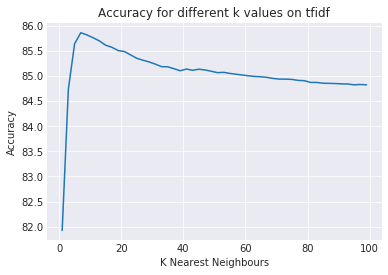

In [42]:
sns.set_style("darkgrid")
plt.plot(np.arange(1,neigh_max,2),k_acc_tfidf)
plt.xlabel("K Nearest Neighbours")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k values on tfidf")
plt.show()

With k=9 bi_gram has the highest accuracy of around 85.9% in Cross Validation

In [47]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train,y_train)
score = knn.score(X_test,y_test)
print("Accuracy on training set: %0.3f%%"%(score*100))

Accuracy on training set: 84.040%


## Gensim
Gensim is a robust open-source vector space modeling and topic modeling toolkit implemented in Python. It uses NumPy, SciPy and optionally Cython for performance. Gensim is specifically designed to handle large text collections, using data streaming and efficient incremental algorithms, which differentiates it from most other scientific software packages that only target batch and in-memory processing.

## Word2Vec
[Refer Docs] :https://radimrehurek.com/gensim/models/word2vec.html 

In [8]:
w2vec_model = gensim.models.Word2Vec.load('w2vmodel') #Loading the model from file in the disk trained in EDA on complete dataset

In [9]:
w2v_vocub = w2vec_model.wv.vocab
len(w2v_vocub)

34906

In [10]:
w2vec_model.wv.most_similar('tast')

[('flavorsso', 0.5832007527351379),
 ('reed', 0.5580089688301086),
 ('preground', 0.541571319103241),
 ('guin', 0.5115907192230225),
 ('lowfat', 0.5012710094451904),
 ('grammar', 0.5010131597518921),
 ('keiller', 0.49844658374786377),
 ('themwhil', 0.4952102601528168),
 ("bulb'", 0.48679518699645996),
 ('itnext', 0.4758400321006775)]

In [12]:
list_of_sent=[]
for sent in df_sample['CleanedText'].values:
    sentence=[]
    for w in sent.split():    
            sentence.append(w) 
    list_of_sent.append(sentence)

In [14]:
w2vec_model.wv['tast']

array([ 0.0078175 ,  0.00240794,  0.00192272,  0.00973465, -0.00494627,
       -0.00143133, -0.00332859, -0.00203311, -0.00496661,  0.00711489,
       -0.00895142, -0.00138186,  0.00392423,  0.00494286,  0.004079  ,
       -0.00060105,  0.00106068, -0.00353141,  0.00098447, -0.00206113,
        0.00185607,  0.00986566, -0.00648976,  0.00141037, -0.00687073,
       -0.00957662, -0.00299725, -0.00439115,  0.00275984,  0.00096321,
        0.00763292,  0.00440738,  0.00315914,  0.00276639, -0.00862832,
       -0.00382569,  0.00372519, -0.00635617,  0.00257477,  0.0037355 ,
        0.00481135,  0.00269675,  0.00314493,  0.00578195, -0.00579357,
        0.0085771 ,  0.0083689 , -0.00441553,  0.00885531,  0.00583697], dtype=float32)

## Avg Word2Vec
* One of the most naive but good ways to convert a sentence into a vector
* Convert all the words to vectors and then just take the avg of the vectors the resulting vector represent the sentence 

In [15]:
%%time
avg_vec = [] #List to store all the avg w2vec's 
# np.seterr(divide='ignore', invalid='ignore')
for sent in list_of_sent:
    cnt = 0 #to count no of words in each reviews
    sent_vec = np.zeros(50) #Initializing with zeroes
    for word in sent:
        try:
            word = word.decode("utf-8") #Decoding from byte string to unicode string
            wvec = w2vec_model.wv[word] #Vector of each using w2v model
            sent_vec += wvec #Adding the vectors 
            cnt += 1
        except: 
            pass #When the word is not in the dictionary then do nothing 
    sent_vec /= cnt #Taking average of vectors sum of the particular review
    avg_vec.append(sent_vec) #Storing the avg w2vec's for each review

CPU times: user 6.32 s, sys: 12 ms, total: 6.33 s
Wall time: 6.33 s


In [16]:
np.isnan(avg_vec).any()

False

In [17]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

avg_vec_norm = preprocessing.normalize(avg_vec)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(avg_vec_norm,df_sample['Score'].values,test_size=0.3,shuffle=False)

In [18]:
avg_vec_norm.shape

(25000, 50)

In [19]:
avg_vec_norm.max()

0.63684579255016116

In [ ]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='brute')
param_grid = {'n_neighbors':np.arange(1,100,2)}
tscv = TimeSeriesSplit(n_splits=10) #For 
gsv = GridSearchCV(knn,param_grid,cv=tscv,n_jobs=-1)
gsv.fit(X_train,y_train)
print(gsv.best_score_)

In [1]:
%%time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
n_splits = 10  #No of splits for forward chaining Cross Validation 
neigh_max = 100#Max no. of neighbours for KNN

tscv = TimeSeriesSplit(n_splits=n_splits)
k_acc = []
for k in range(1,neigh_max,2):
    acc_list = []
    for train, cv in tscv.split(X_train):
          if(train.size > k): 
            knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute',n_jobs=-1)
            knn.fit(X_train[train],y_train[train])
            acc_list.append(knn.score(X_train[cv],y_train[cv])*100)
    if(acc_list):        
        acc_nparr = np.array(acc_list) 
    k_acc.append(acc_nparr.mean())
k_acc = np.array(k_acc)    

#Saving the variable to access later without recomputing
savetofile(k_acc,"k_acc_avgw2v")

In [ ]:
#Loading the variable from file
k_acc_avgw2v = openfromfile("k_acc_avgw2v")

In [ ]:
sns.set_style("darkgrid")
plt.plot(np.arange(1,neigh_max,2),k_acc_tfidf)
plt.xlabel("K Nearest Neighbours")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k values on tfidf")
plt.show()

With k=9 bi_gram has the highest accuracy of around 85.9% in Cross Validation

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train,y_train)
score = knn.score(X_test,y_test)
print("Accuracy on training set: %0.3f%%"%(score*100))

## Tf-idf W2Vec
* Another way to covert sentence into vectors
* Take weighted sum of the vectors divided by the sum of all the tfidf's 
<br>i.e. (tfidf(word) x w2v(word))/sum(tfidf's)

In [ ]:
%%time
tfidfw2v_vecs = [] #List to store all the tfidf w2vec's 
review = 0
for sent in list_of_sent:
    weighted_sum  = 0 
    sent_vec = np.zeros(50) #Initializing with zeroes
    for word in sent:
        try:
            word = word.decode("utf-8") #Decoding from byte string to unicode string
            wvec = w2vec_model.wv[word] #Vector of each using w2v model
            sent_vec += (wvec * tfidf)
            weighted_sum += tfidf 
        except: 
            pass #When the word is not in the dictionary then do nothing 
    sent_vec /= weighted_sum
    tfidf_w2vecs.append(sent_vec)
    review += 1
    

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

tfidfw2v_vecs_norm = preprocessing.normalize(tfidfw2v_vecs)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(tfidfw2v_vecs_norm,df_sample['Score'].values,test_size=0.3,shuffle=False)

In [ ]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='brute')
param_grid = {'n_neighbors':np.arange(1,100,2)}
tscv = TimeSeriesSplit(n_splits=10) #For 
gsv = GridSearchCV(knn,param_grid,cv=tscv,n_jobs=-1)
gsv.fit(X_train,y_train)
print(gsv.best_score_)

In [ ]:
%%time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
n_splits = 10  #No of splits for forward chaining Cross Validation 
neigh_max = 100#Max no. of neighbours for KNN

tscv = TimeSeriesSplit(n_splits=n_splits)
k_acc = []
for k in range(1,neigh_max,2):
    acc_list = []
    for train, cv in tscv.split(X_train):
          if(train.size > k): 
            knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute',n_jobs=-1)
            knn.fit(X_train[train],y_train[train])
            acc_list.append(knn.score(X_train[cv],y_train[cv])*100)
    if(acc_list):        
        acc_nparr = np.array(acc_list) 
    k_acc.append(acc_nparr.mean())
k_acc = np.array(k_acc)    

#Saving the variable to access later without recomputing
savetofile(k_acc,"k_acc_avgw2v")

In [ ]:
#Loading the variable from file
k_acc_tfidfw2v = openfromfile("k_acc_tfidfw2v")

In [ ]:
sns.set_style("darkgrid")
plt.plot(np.arange(1,neigh_max,2),k_acc_tfidfw2v)
plt.xlabel("K Nearest Neighbours")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k values on tfidf w2v")
plt.show()

With k=9 tfidfw2v has the highest accuracy of around 85.9% in Cross Validation

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train,y_train)
score = knn.score(X_test,y_test)
print("Accuracy on training set: %0.3f%%"%(score*100))

tfidf w2vec gives the best result in classifying the reviews as positive or negative

## References:
(1) http://blog.aylien.com/10-common-nlp-terms-explained-for-the-text/<br>
(2) https://en.wikipedia.org/<br>
(3) https://buhrmann.github.io/tfidf-analysis.html<br>